In [5]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

from temp import NeuralPix2Vid
from neuralop.models import FNO, UNO as UFNO

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from temp import check_torch
device = check_torch()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------


In [6]:
sec2year   = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76
co2_rho    = 686.5266
mega       = 1e6

n_timesteps = 33
nx, ny, nz, nz_short  = 100, 100, 11, 5

indexMap = loadmat('data_100_100_11/G_cells_indexMap.mat', simplify_cells=True)['gci']
Grid = np.zeros((nx,ny,nz)).flatten(order='F')
Grid[indexMap] = 1
Grid = Grid.reshape(nx,ny,nz, order='F')
Tops = np.load('data_npy_100_100_11/tops_grid.npz')['tops']
print('Grid: {} | Tops: {}'.format(Grid.shape, Tops.shape))

Grid_short = Grid[:,:,5:10]
Grid_ext = np.repeat(np.expand_dims(Grid, 0), 33, axis=0)
Grid_short_ext = np.repeat(np.expand_dims(Grid_short, 0), 33, axis=0)
print('Grid_ext: {} | Grid_short_ext: {}'.format(Grid_ext.shape, Grid_short_ext.shape))

Grid: (100, 100, 11) | Tops: (100, 100, 11)
Grid_ext: (33, 100, 100, 11) | Grid_short_ext: (33, 100, 100, 5)


In [7]:
np.arange(33)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [8]:
train_size = 4

train_idx = np.random.choice(range(1272), size=train_size, replace=False)
test_idx  = np.setdiff1d(range(1272), train_idx)

xm = np.zeros((len(train_idx), 5, 100,100,5))
xc = np.zeros((len(train_idx), n_timesteps, 5))
xt = np.zeros((len(train_idx), n_timesteps, 1))
yy = np.zeros((len(train_idx), 33, 2, 100,100,5))

def apply_mask(x, imap=indexMap, mask_value=0.0):
    xx = mask_value*np.ones((nx,ny,nz)).flatten(order='F')
    xx[imap] = x.flatten(order='F')[imap]
    xx = xx.reshape((nx,ny,nz), order='F')
    return xx

for i in range(len(train_idx)):
    w = np.zeros((100,100,11))
    m = np.load('data_npy_100_100_11/inputs_rock_rates_locs_time/x_{}.npz'.format(train_idx[i]))
    p = np.expand_dims(apply_mask(m['poro']), 0)[...,5:10] / (0.3)
    k = np.expand_dims(apply_mask(m['perm']), 0)[...,5:10] / (3.3)
    w[m['wlist'][0,:], m['wlist'][1,:], :] = 1
    w = np.expand_dims(apply_mask(w), 0)[...,5:10]
    t = np.expand_dims(apply_mask(Tops), 0)[...,5:10] / (Tops.max())
    g = np.expand_dims(Grid, 0)[...,5:10]
    xm[i] = np.concatenate([p,k,w,t,g], 0)

    xc[i] = m['ctrl'] *co2_rho*sec2year/mega/1e3 / (25)
    xt[i] = m['time']

    dd = np.load('data_npy_100_100_11/outputs_pressure_saturation/y_{}.npz'.format(train_idx[i]))
    prm = dd['pressure'][...,5:10] / (psi2pascal)
    sam = dd['saturation'][...,5:10]
    yy[i,:,0] = np.expand_dims(prm, 0)
    yy[i,:,1] = np.expand_dims(sam, 0)

In [9]:
x_m_tensor = torch.tensor(xm, dtype=torch.float32)
x_c_tensor = torch.tensor(xc, dtype=torch.float32)
x_t_tensor = torch.tensor(xt, dtype=torch.float32)
y_tensor = torch.tensor(yy, dtype=torch.float32)
print('xm', x_m_tensor.shape)
print('xc', x_c_tensor.shape)
print('xt', x_t_tensor.shape)
print('yy', y_tensor.shape)

xm torch.Size([4, 5, 100, 100, 5])
xc torch.Size([4, 33, 5])
xt torch.Size([4, 33, 1])
yy torch.Size([4, 33, 2, 100, 100, 5])


In [10]:
class AdaptiveONet(nn.Module):
    def __init__(self, in_ch:int, out_ch:int=128, n_layers=5, activation=F.gelu, dropout=0.1,
                 transformer_num_layers:int=3, 
                 transformer_nhead:int=4,
                 transformer_dim_feedforward:int=1024, 
                 transformer_activation=F.gelu):
        super(AdaptiveONet, self).__init__()
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.lift = nn.Linear(in_ch, out_ch)
        self.norm = nn.LayerNorm(out_ch)
        self.layers = nn.ModuleList([nn.Linear(out_ch, out_ch) for _ in range(n_layers)])

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=out_ch, 
                nhead=transformer_nhead, 
                dim_feedforward=transformer_dim_feedforward, 
                activation=transformer_activation,
                batch_first=True),
            num_layers=transformer_num_layers)
        
    def forward(self, x):
        x = self.dropout(self.activation(self.norm(self.lift(x))))
        for layer in self.layers:
            x = self.dropout(self.activation(self.norm(layer(x))))
        x = self.transformer(x)
        return x

In [11]:
class SqueezeExcite3d(nn.Module):
    def __init__(self, channels, ratio=4):
        super(SqueezeExcite3d, self).__init__()
        self.ratio = ratio
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excite1 = nn.Linear(channels, channels//ratio)
        self.excite2 = nn.Linear(channels//ratio, channels)

    def forward(self, x):
        b, c, _, _, _ = x.size()
        se_tensor = self.squeeze(x).view(b,c)
        se_tensor = F.relu(self.excite1(se_tensor))
        se_tensor = torch.sigmoid(self.excite2(se_tensor)).view(b,c,1,1,1)
        scaled_inputs = x * se_tensor.expand_as(x)
        return x + scaled_inputs

In [12]:
class SpatialEncoder(nn.Module):
    def __init__(self, in_ch:int=5, hidden_ch=[15,45,135], projection_ch:int=128, input_shape=(100,100,5),
                 kernel_size=3, padding=1, return_sequence:bool=True):
        super(SpatialEncoder, self).__init__()
        k, p = kernel_size, padding
        h, w, d = input_shape
        self.return_sequence = return_sequence
        self.conv1 = nn.Conv3d(in_ch, hidden_ch[0], kernel_size=k, padding=p, groups=in_ch)
        self.conv2 = nn.Conv3d(hidden_ch[0], hidden_ch[1], kernel_size=k, padding=p, groups=hidden_ch[0])
        self.conv3 = nn.Conv3d(hidden_ch[1], hidden_ch[2], kernel_size=k, padding=p, groups=hidden_ch[1])
        self.sae1 = SqueezeExcite3d(hidden_ch[0])
        self.sae2 = SqueezeExcite3d(hidden_ch[1])
        self.sae3 = SqueezeExcite3d(hidden_ch[2])
        self.norm1 = nn.GroupNorm(hidden_ch[0], hidden_ch[0])
        self.norm2 = nn.GroupNorm(hidden_ch[1], hidden_ch[1])
        self.norm3 = nn.GroupNorm(hidden_ch[2], hidden_ch[2])
        self.act = nn.GELU()
        self.pool1 = nn.AdaptiveMaxPool3d((h//2,w//2,d))
        self.pool2 = nn.AdaptiveMaxPool3d((h//4,w//4,d))
        self.pool3 = nn.AdaptiveMaxPool3d((h//8,w//8,d))
        self.project = nn.Linear(hidden_ch[2], projection_ch)

    def forward(self,x):
        z1 = self.sae1(self.conv1(x))
        z  = self.pool1(self.act(self.norm1(z1)))

        z2 = self.sae2(self.conv2(z))
        z  = self.pool2(self.act(self.norm2(z2)))

        z3 = self.sae3(self.conv3(z))
        z  = self.pool3(self.act(self.norm3(z3)))

        z4 = self.project(z.permute(0,2,3,4,1)).permute(0,4,1,2,3)
        b, c, h, w, d = z4.shape
        z  = z4.reshape(b, c, h*w*d)
        
        return z if self.return_sequence else z, (z1,z2,z3,z4)

In [24]:
branch_m = SpatialEncoder()
branch_c = AdaptiveONet(in_ch=5)
branch_t = AdaptiveONet(in_ch=1)
print('M# params: {:,}'.format(sum(p.numel() for p in branch_m.parameters() if p.requires_grad)))
print('C# params: {:,}'.format(sum(p.numel() for p in branch_c.parameters() if p.requires_grad)))
print('T# params: {:,}'.format(sum(p.numel() for p in branch_t.parameters() if p.requires_grad)))

zm, hm = branch_m(x_m_tensor)
zc = branch_c(x_c_tensor)
zt = branch_t(x_t_tensor)

zb = torch.einsum('bcp,btc->btcp', zm, zc)
zz = torch.einsum('btc,btcp->btcp', zt, zb).permute(0,2,1,3)
print(zz.shape)

M# params: 33,490
C# params: 1,073,152
T# params: 1,072,640
torch.Size([4, 128, 33, 720])


UFNO# params: 16,583,170
torch.Size([4, 2, 33, 720])


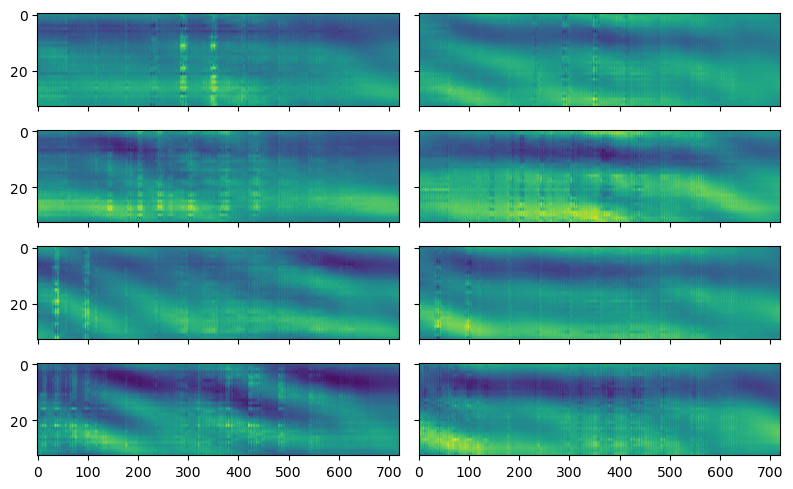

In [55]:
mode1, mode2 = 3, 10
ufno = UFNO(uno_n_modes=[[mode1,mode2],[mode1,mode2],[mode1,mode2],[mode1,mode2],[mode1,mode2]],
            uno_out_channels=[128,256,512,256,128],
            uno_scalings=[[1,1],[1,1],[1,1],[1,1],[1,1]],
            in_channels=128, lifting_channels=256, hidden_channels=256, projection_channels=256, out_channels=2,
            n_layers=5)

print('UFNO# params: {:,}'.format(sum(p.numel() for p in ufno.parameters() if p.requires_grad)))
zy = ufno(zz)
print(zy.shape)

fig, axs = plt.subplots(4, 2, figsize=(8,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(2):
        ax = axs[i,j]
        d = zy[i,j].detach().numpy()
        ax.imshow(d, aspect='auto')
plt.tight_layout()
plt.show()

FNO# params: 12,290,562
torch.Size([4, 2, 33, 720])


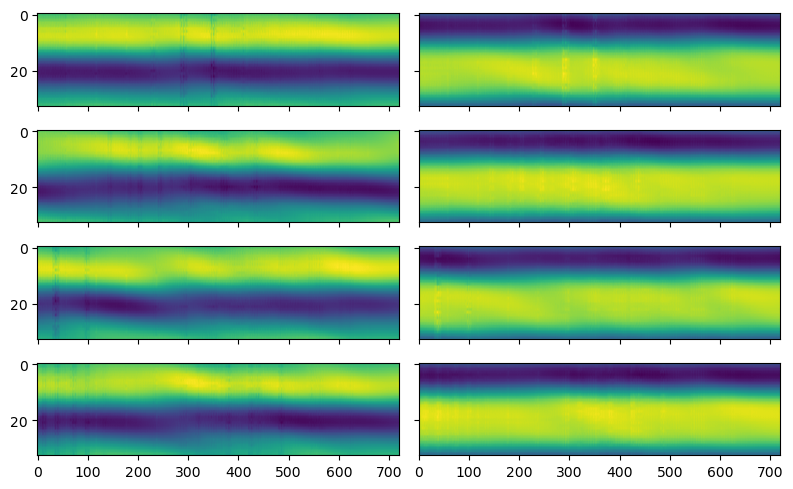

In [59]:
fno = FNO(n_modes=((3,10)),
          in_channels=128, lifting_channels=256, hidden_channels=256, projection_channels=256, out_channels=2, 
          n_layers=5)

print('FNO# params: {:,}'.format(sum(p.numel() for p in fno.parameters() if p.requires_grad)))
zy = fno(zz)
print(zy.shape)

fig, axs = plt.subplots(4, 2, figsize=(8,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(2):
        ax = axs[i,j]
        d = zy[i,j].detach().numpy()
        ax.imshow(d, aspect='auto')
plt.tight_layout()
plt.show()

In [44]:
zy = zz.permute(0,2,1,3)
print(zy.shape)

torch.Size([4, 33, 128, 720])


In [60]:
fcQ = nn.Linear(720, 29128)

yh = fcQ(zy)
print(yh.shape)

torch.Size([4, 2, 33, 29128])


In [ ]:
train_dataset = TensorDataset(x_m_tensor[:-10], x_c_tensor[:-10], x_t_tensor[:-10], y_tensor[:-10])
valid_dataset = TensorDataset(x_m_tensor[-10:], x_c_tensor[-10:], x_t_tensor[-10:], y_tensor[-10:])

trainloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=10, shuffle=False)

In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIMLoss
from torchmetrics.image import SpatialCorrelationCoefficient as SCCLoss
from torchmetrics.image import SpectralDistortionIndex as SDILoss
from torchmetrics.image import UniversalImageQualityIndex as UIQILoss
from torchmetrics.image import VisualInformationFidelity as VIFLoss

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.7):
        super(CustomLoss, self).__init__()
        self.ssim = SSIMLoss()
        self.mse  = nn.MSELoss()
        self.mae  = nn.L1Loss()
        self.alpha = alpha
        self.beta  = beta

    def forward(self, true, pred):
        ridge_loss = self.beta*self.mse(true, pred) + (1-self.beta)*self.mae(true, pred)
        visual_loss = 1-self.ssim(true, pred)
        total_loss = self.alpha*ridge_loss + (1-self.alpha)*visual_loss
        return total_loss

In [ ]:
model = NeuralPix2Vid().to(device)
print('# parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = CustomLoss().to(device)

# parameters: 34,631,418


In [ ]:
epochs, monitor = 101, 10
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, (xm, xw, xc, xt, y) in enumerate(trainloader):
        optimizer.zero_grad()
        xm = xm.to(device)
        xw = xw.to(device)
        xc = xc.to(device)
        xt = xt.to(device)
        yt = y.to(device)
        yh = model(xm, xw, xc, xt).to(device)
        loss = criterion(yt, yh)
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for i, (xmv, xwv, xcv, xtv, yv) in enumerate(validloader):
            xmv = xmv.to(device)
            xwv = xwv.to(device)
            xcv = xcv.to(device)
            xtv = xtv.to(device)
            yv = yv.to(device)
            yhv = model(xmv, xwv, xcv, xtv).to(device)
            loss = criterion(yv, yhv)
            epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # print
    if epoch % monitor == 0:
        print('Epoch: [{}/{}] | Loss: {:.4f} | Valid Loss: {:.4f}'.format(
            epoch+1, epochs, train_loss[-1], valid_loss[-1]))

torch.save(model.state_dict(), 'neuralpix2vid.pth')
pd.DataFrame({'train': train_loss, 'valid': valid_loss}).to_csv('neuralpix2vid_losses.csv', index=False)

RuntimeError: Padding size should be less than the corresponding input dimension, but got: padding (5, 5) at dimension 2 of input [10, 33, 2, 50000]

***
# END